<a href="https://colab.research.google.com/github/nyac-1/trading-financial-announcements/blob/main/Book_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

from google.colab import drive; drive.mount('/content/gdrive', force_remount=True)
%cd '/content/gdrive/My Drive/Colab Notebooks'

import pandas as pd
import glob

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks


In [2]:
df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/checkpoint.csv")
df.head()

,sent,file
0,2,/content/gdrive/My Drive/aem/16-Jun-2022 Gener...
1,2,/content/gdrive/My Drive/aem/16-Jun-2022 Gener...
2,0,/content/gdrive/My Drive/aem/13-Jun-2022 Discl...
3,0,/content/gdrive/My Drive/aem/13-Jun-2022 Discl...
4,0,/content/gdrive/My Drive/aem/10-Jun-2022 Gener...


In [3]:
!pip install pdflib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 4.9 MB/s 


In [4]:
from pdflib import Document
dir='/content/gdrive/My Drive'
pdfs = glob.glob(dir+'/aem/*.pdf')

In [5]:
import re

dtLs=[]
for f in pdfs:
  dt=re.findall(r'\d{2}-\w{3}-\d{4}',f)[0]
  dtLs.append(dt)


In [6]:
df['date']=dtLs
df.head()

df['date']=pd.to_datetime(df['date'])
df.set_index('date',inplace=True)
df.head()

,sent,file
date,,
2022-06-16,2,/content/gdrive/My Drive/aem/16-Jun-2022 Gener...
2022-06-16,2,/content/gdrive/My Drive/aem/16-Jun-2022 Gener...
2022-06-13,0,/content/gdrive/My Drive/aem/13-Jun-2022 Discl...
2022-06-13,0,/content/gdrive/My Drive/aem/13-Jun-2022 Discl...
2022-06-10,0,/content/gdrive/My Drive/aem/10-Jun-2022 Gener...


In [7]:
sent=df.groupby(df.index).sent.sum()
sent.head()

date
2020-02-24    0
2020-02-25    7
2020-02-26    8
2020-02-28    0
2020-03-02    0
Name: sent, dtype: int64

In [8]:
##backtesting

In [9]:
!pip install backtrader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 410 kB 4.9 MB/s 


In [10]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt


# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('exitbars', 0),
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        self.datasent = self.datas[0].sent

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.datasent[0] >2:
              # BUY, BUY, BUY!!! (with default parameters)
              self.log('BUY CREATE, %.2f' % self.dataclose[0])

              # Keep track of the created order to avoid a 2nd order
              self.order = self.buy()

        else:

            # Already in the market ... we might sell
            if len(self) >= (self.bar_executed + self.params.exitbars):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

In [11]:
sent.sort_values(ascending=False)[:10]

date
2022-04-12    24
2021-04-14    19
2021-04-30    14
2022-02-24    14
2020-04-15    12
2020-04-28    12
2020-08-03    11
2022-04-28    10
2022-05-05     8
2020-02-26     8
Name: sent, dtype: int64

In [12]:
sent.sort_values(ascending=True)[:10]

date
2020-02-24    0
2021-03-29    0
2021-04-01    0
2021-04-07    0
2021-04-12    0
2021-04-15    0
2021-04-20    0
2021-04-23    0
2021-03-26    0
2021-04-26    0
Name: sent, dtype: int64

In [13]:
yf=pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/AWX.SI.csv")
yf.Date=pd.to_datetime(yf['Date'])
yf.set_index('Date',inplace=True)

comb=yf.merge(sent,left_index=True,right_index=True,how='left').fillna(0)
comb.head(2)

,Open,High,Low,Close,Adj Close,Volume,sent
Date,,,,,,,
2019-11-01,1.48,1.54,1.46,1.53,1.438929,9248700,0.0
2019-11-04,1.58,1.64,1.58,1.63,1.532976,15033200,0.0


In [14]:
class PandasSent(bt.feeds.PandasData):
  lines=(('sent'),)
  params=(('sent',-1),)

In [15]:
if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(TestStrategy)

    data = PandasSent(dataname=comb)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=100)

    # Set the commission - 0.1% ... divide by 100 to remove the %
    cerebro.broker.setcommission(commission=0.001)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
2019-11-01, Close, 1.53
2019-11-04, Close, 1.63
2019-11-05, Close, 1.63
2019-11-06, Close, 1.76
2019-11-07, Close, 1.81
2019-11-08, Close, 1.81
2019-11-11, Close, 1.71
2019-11-12, Close, 1.79
2019-11-13, Close, 1.75
2019-11-14, Close, 1.76
2019-11-15, Close, 1.78
2019-11-18, Close, 1.87
2019-11-19, Close, 1.85
2019-11-20, Close, 1.82
2019-11-21, Close, 1.79
2019-11-22, Close, 1.80
2019-11-25, Close, 1.79
2019-11-26, Close, 1.78
2019-11-27, Close, 1.79
2019-11-28, Close, 1.71
2019-11-29, Close, 1.80
2019-12-02, Close, 1.96
2019-12-03, Close, 1.94
2019-12-04, Close, 1.92
2019-12-05, Close, 1.95
2019-12-06, Close, 1.93
2019-12-09, Close, 1.91
2019-12-10, Close, 1.89
2019-12-11, Close, 1.89
2019-12-12, Close, 1.90
2019-12-13, Close, 1.93
2019-12-16, Close, 1.92
2019-12-17, Close, 1.90
2019-12-18, Close, 1.91
2019-12-19, Close, 1.89
2019-12-20, Close, 1.86
2019-12-23, Close, 1.85
2019-12-24, Close, 1.89
2019-12-25, Close, 1.89
2019-12-26, Close, 1.88
2019

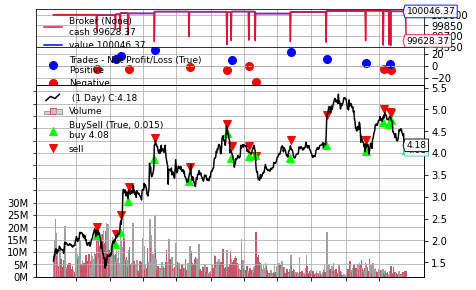

[[<Figure size 432x288 with 4 Axes>]]

In [16]:
cerebro.plot(iplot=False)